# Imports

In [2]:
import matplotlib.pyplot as plt
import pandas as pd
from sklearn.model_selection import train_test_split
from sklearn.preprocessing import LabelEncoder
import seaborn as sns
import warnings
from sklearn.feature_extraction.text import TfidfVectorizer
import spacy
from collections import Counter
from vaderSentiment.vaderSentiment import SentimentIntensityAnalyzer
from sklearn.feature_extraction.text import TfidfVectorizer
from sklearn.ensemble import RandomForestClassifier
from sklearn.metrics import classification_report
from sklearn.pipeline import Pipeline

import re
import nltk


warnings.filterwarnings("ignore")

In [3]:
complaints = pd.read_excel('EaUgXb.xlsx')
complaints

,customerID,complaint,complaint_number
0,9565-DJPIB,The streaming TV service frequently buffers or...,1
1,4342-HFXWS,The DSL internet service has been inconsistent...,1
2,4342-HFXWS,The streaming TV service often buffers excessi...,2
3,4342-HFXWS,"Despite having tech support included, it takes...",3
4,4342-HFXWS,The device protection plan I pay for did not c...,4
...,...,...,...
1600,2325-ZUSFD,The streaming services (TV and movies) have be...,1
1601,2325-ZUSFD,"Despite paying for OnlineSecurity, I've been n...",2
1602,7851-FLGGQ,The streaming movies service I signed up for k...,1
1603,6874-SGLHU,"The streaming services, both TV and movies, fr...",1


In [4]:
# check for any missing values
print("Missing values in test dataset:")
print(complaints.isnull().sum())
print(complaints[complaints.isnull().any(axis=1)])


Missing values in test dataset:
customerID          0
complaint           0
complaint_number    0
dtype: int64
Empty DataFrame
Columns: [customerID, complaint, complaint_number]
Index: []


In [5]:
#check unique values in each column
print("Unique values in each column:")
for col in complaints.columns:
    print(f"{col}: {complaints[col].nunique()} unique values")

Unique values in each column:
customerID: 704 unique values
complaint: 1605 unique values
complaint_number: 5 unique values


So only 704 customers over the 7043 registered in the other dataset have given feedbacks. Moreover we know that some among the 704 customers have left more than one complaint (up to five).

In [6]:
# count how many customers make just one complaint
print("Count of customers making 1, 2, 3, 4, or 5 complaints:")
n_comp = complaints['customerID'].value_counts().value_counts()
print(n_comp, "\n")

perc=n_comp[1]/704
perc = round(perc, 4)
print(f"Percentage of customers making just one complaint: {perc*100}%")


Count of customers making 1, 2, 3, 4, or 5 complaints:
count
1    298
3    134
2    128
5     73
4     71
Name: count, dtype: int64 

Percentage of customers making just one complaint: 42.33%


In [7]:
# check mean of complaint number
print("Mean of complaint number:")
mean_complaint = complaints['complaint_number'].mean()
print(mean_complaint)

Mean of complaint number:
2.0504672897196263


Although 42.33% of customers only submit one complaint, the average number of complaints per customer is 2, indicating that while most customers do not return after their first issue, a smaller subset of highly dissatisfied customers engages in repeated complaints. This suggests a bifurcation in customer experience: some may churn silently after one negative interaction, while others persist in seeking resolution.

This pattern emphasizes the need to take first complaints seriously, as a large portion of customers may never return if the issue is not adequately resolved. On the other hand, customers who complain multiple times may require structured support, as they represent a group at high risk of dissatisfaction and potential churn.

---

## **SENTIMENT ANALYSIS**

This sentiment analysis wants to focus on the negativity because we know the dataset is made only of complaints (negative feedbacks) of customers, so, for sure, all of them are negative; but at what intensity? \
Our aim is to classify the complaints in three levels of intensity (mild, moderate, severe)

**STRATEGY**
1. Implementing a pretrained model (VADER) 
    We can use it to have a quick baseline model working for unlabeled data.
2. Labeling or Defining the Sentiment
    If possible, manually label a small sample (~100 complaints) for a custom supervised model (better but more work)
3. Modeling
    Train a classifier (Logistic Regression, Random Forest, fine-tune a Transformer like BERT, etc.)

In [8]:
def preprocess_text(text):
    text = re.sub(r'[^a-zA-Z\s]', '', text)  # Remove special characters
    text = text.lower()  # Convert to lowercase
    return text

In [9]:
complaints['cleaned_complaint'] = complaints['complaint'].apply(preprocess_text)

### Using VADER (pretrained, unlabeled)

We implement a specialized model to classify the intensity of negativity in complaints, based also on VADER's sentiment analysis. VADER provides four sentiment scores (positive, negative, neutral, and compound), but for complaint analysis, we need a more focused approach that specifically measures negativity intensity.

We create a custom scoring system that examines and weights particular words in each complaint. Instead of using VADER's standard scores, our approach identifies domain-specific negative terms, urgency expressions, and intensifiers that appear frequently in our complaints dataset, assigning different weights to words that signal moderate negativity (like "disappointing") versus severe negativity (like "outrageous"). 

The final negativity score, calculated by summing these weighted word scores, is then used to classify complaints into severity categories using thresholds, providing a tailored assessment of negativity intensity specific to our business context.

In [10]:

# Load English language model
nlp = spacy.load("en_core_web_sm")

# Function to extract adjectives and adverbs
def extract_adj_adv_spacy(text):
    # Process text with spaCy
    doc = nlp(text.lower())
    
    # Extract adjectives and adverbs based on their POS tags
    adjectives = [token.text for token in doc if token.pos_ == "ADJ"]
    adverbs = [token.text for token in doc if token.pos_ == "ADV"]
    
    return adjectives, adverbs



In [11]:
# Process complaints
all_adjectives = []
all_adverbs = []
# To handle large datasets efficiently, process in batches
for complaint in complaints['complaint']:
    adj, adv = extract_adj_adv_spacy(complaint)
    all_adjectives.extend(adj)
    all_adverbs.extend(adv)

# Count frequencies
adj_freq = Counter(all_adjectives)
adv_freq = Counter(all_adverbs)




In [12]:
top_adjectives = adj_freq.most_common(20)
print("Top 20 Adjectives:")
for adj, count in top_adjectives:
    print(f"{adj}: {count}")


Top 20 Adjectives:
monthly: 332
high: 319
frustrating: 267
slow: 195
frequent: 169
online: 159
difficult: 147
poor: 139
unreliable: 132
impossible: 131
long: 123
unacceptable: 116
better: 102
multiple: 97
unhelpful: 95
inconsistent: 91
loyal: 88
basic: 78
ongoing: 64
available: 58


In [13]:
top_adverbs = adv_freq.most_common(20)
print("\nTop 20 Adverbs:")
for adv, count in top_adverbs:
    print(f"{adv}: {count}")


Top 20 Adverbs:
especially: 189
extremely: 171
frequently: 159
very: 142
even: 110
too: 98
often: 95
consistently: 90
constantly: 55
immediately: 48
still: 46
altogether: 43
effectively: 37
recently: 36
online: 34
properly: 32
much: 31
lately: 30
more: 30
long: 29


Now we define a function where the score is calculated based which specific negative words appear in a complaint, then we weight the score also with the vader scores (neg and compound) and finally there is the thresholding used for the classification of intensity level of the single complaint.

In [14]:
def vader_classifier(text):
    # Get VADER scores
    sia = SentimentIntensityAnalyzer()
    scores = sia.polarity_scores(text)
    
    # Extract scores
    neg_score = scores['neg']
    compound = scores['compound']
    
    severity_score = 0
    
    # Defining severe negative words
    severe_words = ["terrible", "worst", "horrible", "awful", "outrageous", 
                   "unacceptable", "disgusting", "appalling", "furious", 
                   "ridiculous", "scam", "fraud", "lawsuit", "legal action", 
                   "frustrating", "frustrat" "dissatisfied", "unreliable", 
                   "cancel", "frustrated", "loyal", "loyalty",  "no loyalty",
                   "long-term", "impossible"]

    
    # Defining moderate negative words
    moderate_words = ["disappointed", "disappointing", "annoying", "problem", 
                     "issue", "issues" "poor", "unhappy", "bad", "seem", "inconvenient", 
                     "expect", "delay", "wait", "slow", "difficult", "confusing", 
                     "unresolved", "unhelpful", "expected", "unresponsive", "slower", 
                     "slow", "inconsistent", "poor"]

    # Defining intensifiers
    intensifiers = ["very", "extremely", "absolutely", "completely", "totally", "excessively", "excessive", "high", "especially", "properly"]

    
    # Defining urgency indicators
    urgency_words = ["immediately", "urgent", "asap", "right away", "emergency"]

    
    for word in text.lower().split():
        if word in severe_words:
            severity_score += 3
        if word in moderate_words:
            severity_score += 2
        if word in intensifiers:
            severity_score += 1
        if word in urgency_words:
            severity_score += 2

    
    # Weight with VADER scores
    severity_score += (neg_score * 5)  # Multiply negative score for more weight
    severity_score -= (compound * 3)   # Subtract compound (since negative compound is negative)

    # Tresholding classification
    if severity_score > 4:
        return 'severe'
    elif severity_score > 1:
        return 'moderate'
    else:
        return 'mild'
    

In [15]:
complaints['severity'] = complaints['cleaned_complaint'].apply(vader_classifier)


Then we check and we visualize the distribution of the negativity classes

In [16]:

# Check the distribution
severity_distribution = complaints['severity'].value_counts()
print(severity_distribution)


severity
severe      954
moderate    452
mild        199
Name: count, dtype: int64


Text(0, 0.5, 'Count')

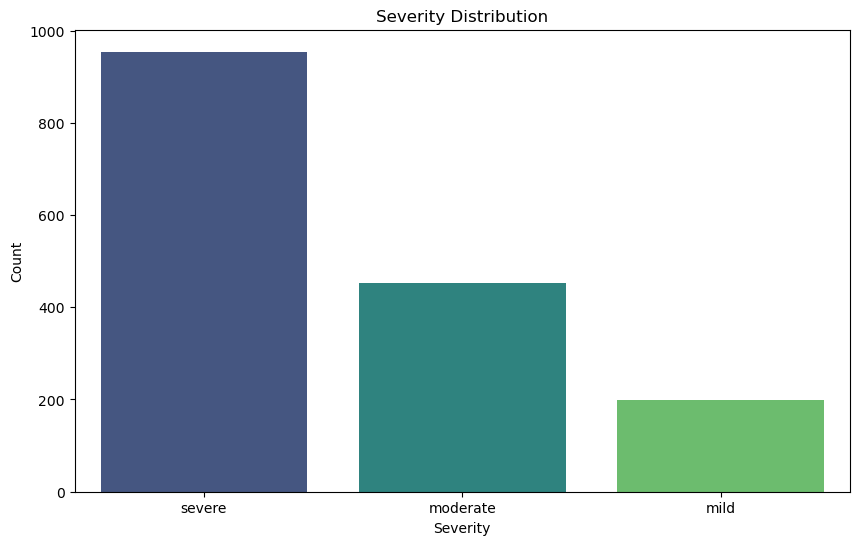

In [17]:
# Plot the results
plt.figure(figsize=(10, 6))
sns.countplot(data=complaints, x='severity', palette='viridis')
plt.title('Severity Distribution')
plt.xlabel('Severity')
plt.ylabel('Count')

### Complaint history analysis

Finally, we have analyzed how complaint severity changes as customers submit multiple complaints over time. Our visualizations reveal patterns in negativity intensity, showing whether customers' complaints tend to become more severe, less severe, or remain consistent with each subsequent submission.

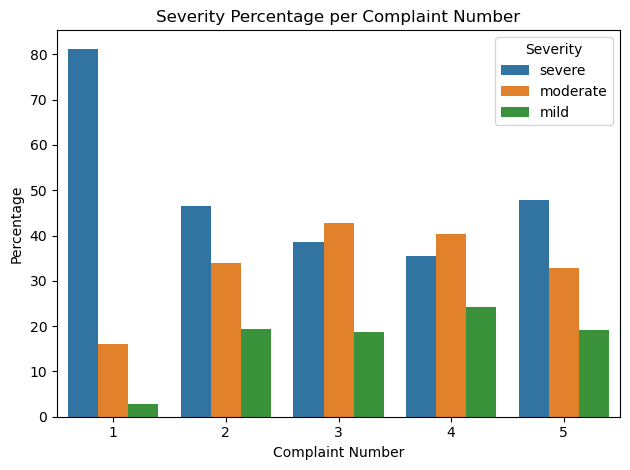

In [18]:
# For each complaint number, calculate the percentage of each severity
severity_percentage = complaints.groupby('complaint_number')['severity'].value_counts(normalize=True) * 100

# Reset index for better visualization
severity_percentage = severity_percentage.reset_index(name='percentage')
# Plotting the trend
sns.barplot(x='complaint_number', y='percentage', hue='severity', data=severity_percentage)
plt.title('Severity Percentage per Complaint Number')
plt.ylabel('Percentage')
plt.xlabel('Complaint Number')
plt.legend(title='Severity')
plt.tight_layout()
plt.show()

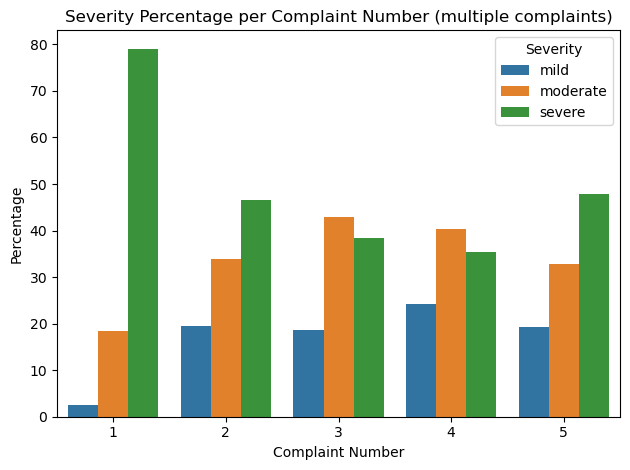

In [19]:
# Filter to get only customers with multiple complaints
complaint_counts = complaints['customerID'].value_counts()
multi_complainers = complaint_counts[complaint_counts > 1].index
multi_complainer_data = complaints[complaints['customerID'].isin(multi_complainers)]

# Calculate percentage of each severity category per complaint number
severity_percentage = pd.crosstab(
    multi_complainer_data['complaint_number'], 
    multi_complainer_data['severity'],  # Assuming 'severity' is your column with severity categories
    normalize='index'  # Normalize by row (complaint number)
) * 100

# Reset index to prepare for plotting
severity_percentage = severity_percentage.reset_index()

# Convert to long format for seaborn
severity_percentage_long = pd.melt(
    severity_percentage, 
    id_vars=['complaint_number'],
    var_name='severity', 
    value_name='percentage'
)

# Plotting the trend
sns.barplot(x='complaint_number', y='percentage', hue='severity', data=severity_percentage_long)
plt.title('Severity Percentage per Complaint Number (multiple complaints)')
plt.ylabel('Percentage')
plt.xlabel('Complaint Number')
plt.legend(title='Severity')
plt.tight_layout()
plt.show()


By looking at how the customers expressed throughout their first, second, third, fourth and fifth complaint, we can notice that the most severe terms are used when people complain for the first, second and fifth time, while in the other cases they use more moderate terms. Actually it make sense that in the first complaint people are very severe because by EDA we saw that more than 40% of complainers only make a single complaint.


The spike in severity in the first complaint supports the idea that first impressions matter greatly — customers who express high negativity early might not remain if their issues aren't resolved promptly. Moreover, the increase in severity at the fifth complaint could suggest that issues are being left unresolved, eventually escalating the customer’s frustration. This highlights the importance of long-term issue resolution. And, customers appear less severe in the third and fourth complaints, which could indicate either that their issues were partially addressed or that they are becoming resigned, which could be a sign preceding churn.

### **Repeating the analysis only with churning customers**

In order to analyze only the churning customers, we need to combined both dataset and we merge only the 'Churn' column from the client's dataset. Then we create a new dataframe filtering only for churning customers and we re-apply the model and visualization methods.

In [19]:
clients = pd.read_excel('btUTgX.xlsx')
clients = clients[['customerID', 'Churn']]
complaints = complaints.merge(clients, on='customerID', how='left')

# take a subset only with churning customers
churning_customers = complaints[complaints['Churn'] == 'Yes']
churning_customers = churning_customers.drop(columns=['severity'])
churning_customers

,customerID,complaint,complaint_number,cleaned_complaint,Churn
0,9565-DJPIB,The streaming TV service frequently buffers or...,1,the streaming tv service frequently buffers or...,Yes
6,8988-ECPJR,The internet service has been very inconsisten...,1,the internet service has been very inconsisten...,Yes
7,8988-ECPJR,I was disappointed to find out that there is n...,2,i was disappointed to find out that there is n...,Yes
8,8988-ECPJR,The monthly charges are too high for the limit...,3,the monthly charges are too high for the limit...,Yes
9,1567-DSCIC,The internet speed with your fiber optic servi...,1,the internet speed with your fiber optic servi...,Yes
...,...,...,...,...,...
1599,2495-INZWQ,When I reached out for support regarding the s...,2,when i reached out for support regarding the s...,Yes
1600,2325-ZUSFD,The streaming services (TV and movies) have be...,1,the streaming services tv and movies have been...,Yes
1601,2325-ZUSFD,"Despite paying for OnlineSecurity, I've been n...",2,despite paying for onlinesecurity ive been not...,Yes
1602,7851-FLGGQ,The streaming movies service I signed up for k...,1,the streaming movies service i signed up for k...,Yes


In [20]:
# Re-apply vader classifier
churning_customers['severity'] = churning_customers['cleaned_complaint'].apply(vader_classifier)

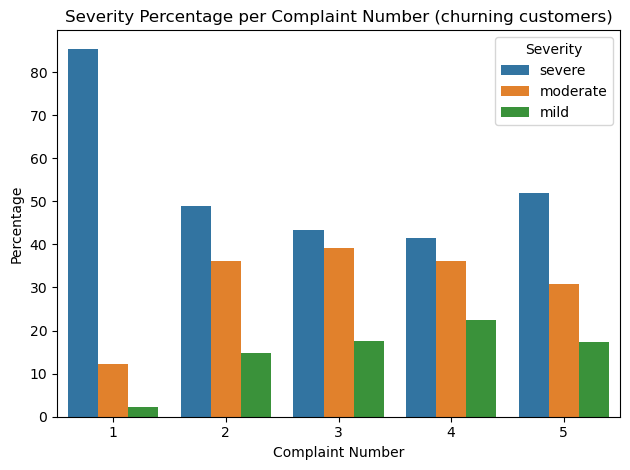

In [21]:
# We calculate the percentage of severity, for each complaint number
severity_percentage2 = churning_customers.groupby('complaint_number')['severity'].value_counts(normalize=True) * 100

# Reset index for better visualization
severity_percentage2 = severity_percentage2.reset_index(name='percentage')
# Plotting the trend
sns.barplot(x='complaint_number', y='percentage', hue='severity', data=severity_percentage2)
plt.title('Severity Percentage per Complaint Number (churning customers)')
plt.ylabel('Percentage')
plt.xlabel('Complaint Number')
plt.legend(title='Severity')
plt.tight_layout()
plt.show()

In this case we can observe that, despite the number of complaint, all customers that are churning complain more severely. The fact that churning customers consistently use more severe language than the general population suggests a strong link between emotional tone and attrition. Monitoring sentiment trends could serve as an early warning system.

Even when making multiple complaints, churners’ severity does not decrease, which may indicate that they are not perceiving resolution or acknowledgment, this can be a sign of failed service recovery. \
Implementing intervention policies based on sentiment (e.g., escalation of complaints with highly severe language) could allow customer service to act before the churn decision is final.

---
## Trained model on small labeled sample

We generate a casual subset file to be manually labeled and that will be the base on which training the model. However, since it is a time-consuming activity, this approach will be tried on a small sample (~100 complaints).

In [44]:
# Take a sample of 110 elements from the dataset
sample_size = 110
complaints = complaints.drop(columns=['severity'])
sampled_complaints = complaints.sample(n=sample_size, random_state=42)
# Save the sampled dataset to an csv file
sampled_complaints.to_csv('sampled_complaints.csv', index=False)


In [45]:
complaints2 = pd.read_csv('labeled_complaints.csv', sep=";")
complaints2

,complaint,severity_label
0,I have been charged a high monthly fee of $79....,moderate
1,The internet speed has been inconsistent latel...,severe
2,When I tried to contact customer support about...,severe
3,Despite having tech support included in my pla...,severe
4,I was charged the full amount this month even ...,moderate
...,...,...
104,The DSL internet speed is much slower than exp...,moderate
105,I’m frustrated with the lack of flexibility or...,severe
106,"My streaming services, both TV and movies, fre...",severe
107,"The monthly charges are extremely high, and I ...",severe


In [46]:
complaints2['cleaned_complaint'] = complaints2['complaint'].apply(preprocess_text)

In [47]:
# Split data into training and testing sets

X = complaints2['cleaned_complaint']
y = complaints2['severity_label']

X_train, X_test, y_train, y_test = train_test_split(
    X, y, test_size=0.2, random_state=42, stratify=y
)


In [48]:

# Create and train a model pipeline
class_weights = {'mild': 5, 'moderate': 2, 'severe': 1}  # Higher weight for underrepresented classes

# This pipeline will vectorize the text and apply a classifier
pipeline = Pipeline([
    ('tfidf', TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
    ('classifier', RandomForestClassifier(n_estimators=100, random_state=42, class_weight=class_weights))
])

# Train the model
pipeline.fit(X_train, y_train)


Pipeline(steps=[('tfidf',
                 TfidfVectorizer(max_features=5000, ngram_range=(1, 2))),
                ('classifier',
                 RandomForestClassifier(class_weight={'mild': 5, 'moderate': 2,
                                                      'severe': 1},
                                        random_state=42))])

In [49]:
# Evaluate the model
predictions = pipeline.predict(X_test)
print("\nClassification Report:")
print(classification_report(y_test, predictions))



Classification Report:
              precision    recall  f1-score   support

        mild       0.00      0.00      0.00         2
    moderate       0.67      0.29      0.40         7
      severe       0.68      1.00      0.81        13

    accuracy                           0.68        22
   macro avg       0.45      0.43      0.40        22
weighted avg       0.62      0.68      0.61        22



Now that we trained and tested the model we try it on the complete dataset, even if from the classification report is evident that it performs poorly on moderate and mild classification. Quite surely we will obtain a biased prediction of majority of complaints being detected as severe.

In [51]:
# use the model on the complete dataset
complaints3 = pd.read_excel('EaUgXb.xlsx')
complaints3['cleaned_complaint'] = complaints3['complaint'].apply(preprocess_text)
complaints3['predicted_severity'] = pipeline.predict(complaints3['cleaned_complaint'])


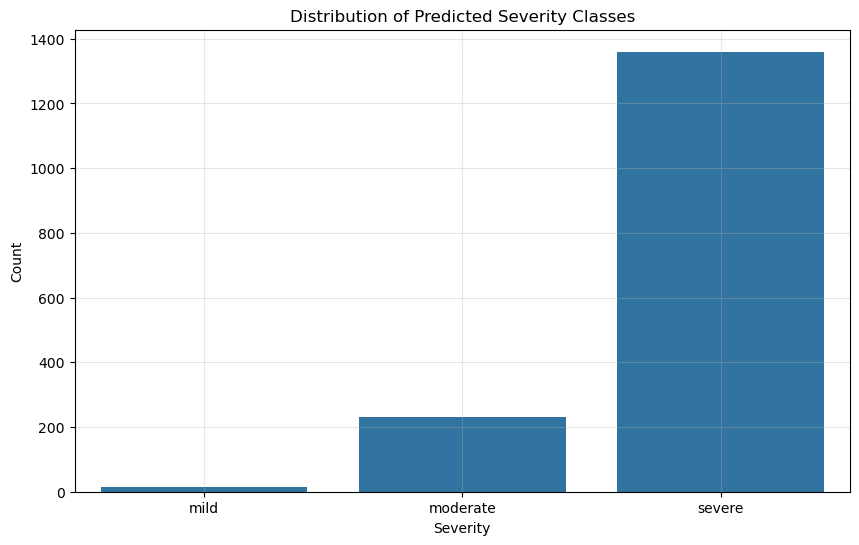

In [52]:
plt.figure(figsize=(10, 6))
sns.countplot(x='predicted_severity', data=complaints3, order=['mild', 'moderate', 'severe'])
plt.title('Distribution of Predicted Severity Classes')
plt.xlabel('Severity')
plt.ylabel('Count')
plt.grid(True, alpha=0.3)
plt.show()


In [53]:
# Check the distribution
severity_distribution3 = complaints3['predicted_severity'].value_counts()
print(severity_distribution3)

predicted_severity
severe      1360
moderate     231
mild          14
Name: count, dtype: int64


As expected it classifies the vast majority of complaints pertaining to the 'severe' class. In fact, applying the visualization methods, we used prior, we will obtain a very biased classification of severe complaints.

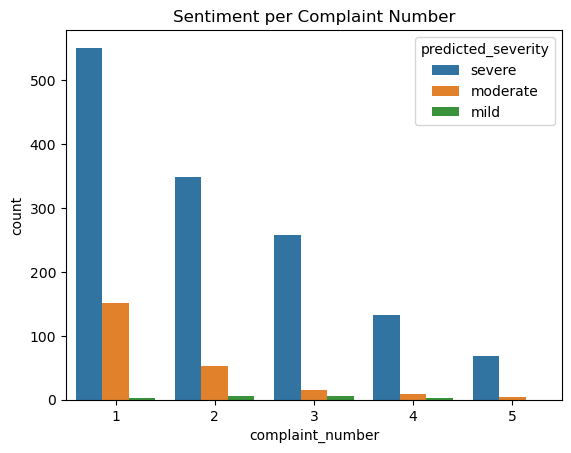

In [54]:
sns.countplot(x='complaint_number', hue='predicted_severity', data=complaints3)
plt.title('Sentiment per Complaint Number')
plt.show()

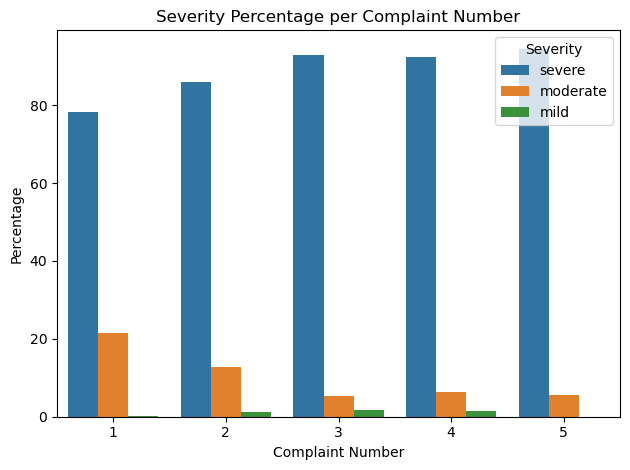

In [55]:
# For each complaint number, calculate the percentage of each severity
severity_percentage = complaints3.groupby('complaint_number')['predicted_severity'].value_counts(normalize=True) * 100

# Reset index for better visualization
severity_percentage = severity_percentage.reset_index(name='percentage')
# Plotting the trend
sns.barplot(x='complaint_number', y='percentage', hue='predicted_severity', data=severity_percentage)
plt.title('Severity Percentage per Complaint Number')
plt.ylabel('Percentage')
plt.xlabel('Complaint Number')
plt.legend(title='Severity')
plt.tight_layout()
plt.show()

For this model there to stress the fact that maybe a too small sample was used to train the model, thus, the prediction has a quite high bias towads 'severe'. As a matter of fact, it is not too useful to draw conclusion from the biased result we obtained above since they could be misleading and incorrect.